In [2]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, ReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import f1_score, classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!nvidia-smi

Tue Oct 10 12:56:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [65]:
###############
# definitions #
###############

# the base directory
    BASE_DIR = "/content/drive/MyDrive/capstone/"

    # the base data directory
    BASE_DATA_DIR = BASE_DIR + "data/"

# dir where final set of imgs are to be read from
final_data_dir = BASE_DATA_DIR + "segregated/"

pos_sample_dir = final_data_dir + "0/"

# train data dir
train_data_dir = BASE_DATA_DIR + "train/"
# test data dir
test_data_dir = BASE_DATA_DIR + "test/"

# hyperparams
batch_size = 32
img_height = img_width = 512

AUTOTUNE = tf.data.AUTOTUNE

Found 1226 files belonging to 1 classes.


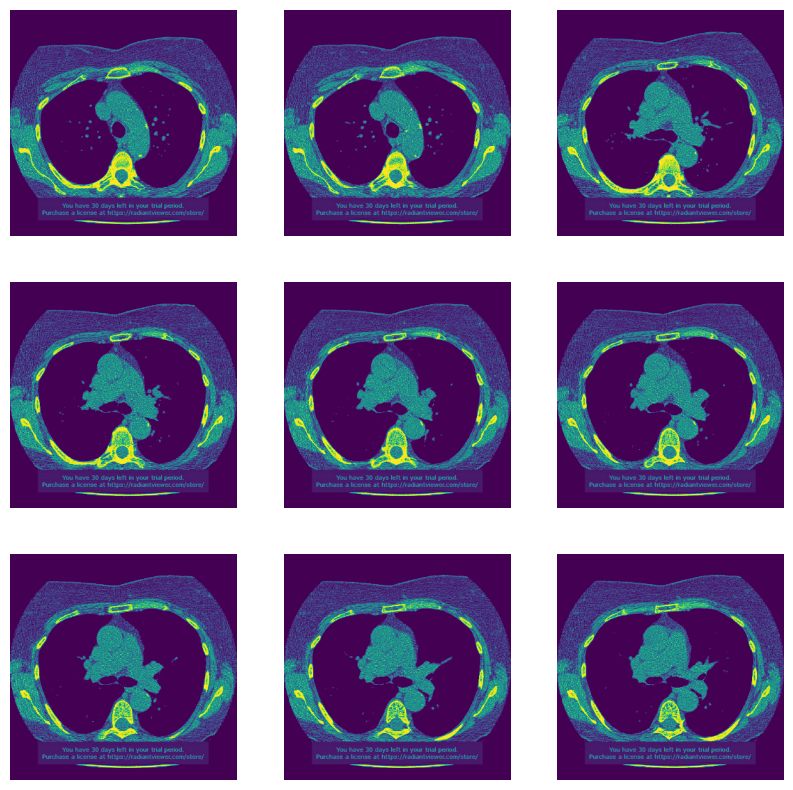

In [23]:
###############
# Data Loader #
###############

# hyperparams
batch_size = 32
img_height = img_width = 320

pos_ds = image_dataset_from_directory(
    pos_sample_dir,
    labels="inferred",
    label_mode=None,
    color_mode="grayscale",
    validation_split=None,
    shuffle=False,
    seed=0,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# sample plot
plt.figure(figsize=(10, 10))
for batch in pos_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(batch[i].numpy().astype("uint8"))
        plt.axis("off")

In [24]:
###########################
# Data Augmentation Model #
###########################

data_augmentation = tf.keras.Sequential(
    [
        layers.RandomTranslation(
            height_factor=(-0.05, 0.05),
            width_factor=(-0.05, 0.05),
            fill_mode="nearest",
        ),
        layers.RandomRotation(
            factor=(-0.025, 0.025),
            fill_mode="nearest",
        ),
        layers.RandomBrightness(
            factor=(-0.2, 0.2)
        ),
        layers.RandomContrast(
            factor=0.2
        ),
        layers.RandomZoom(
            height_factor=(-0.1, 0.025)
        ),
    ]
)

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

aug_ds = pos_ds.map(
    lambda x: data_augmentation(x, training=True),
    num_parallel_calls=AUTOTUNE
)

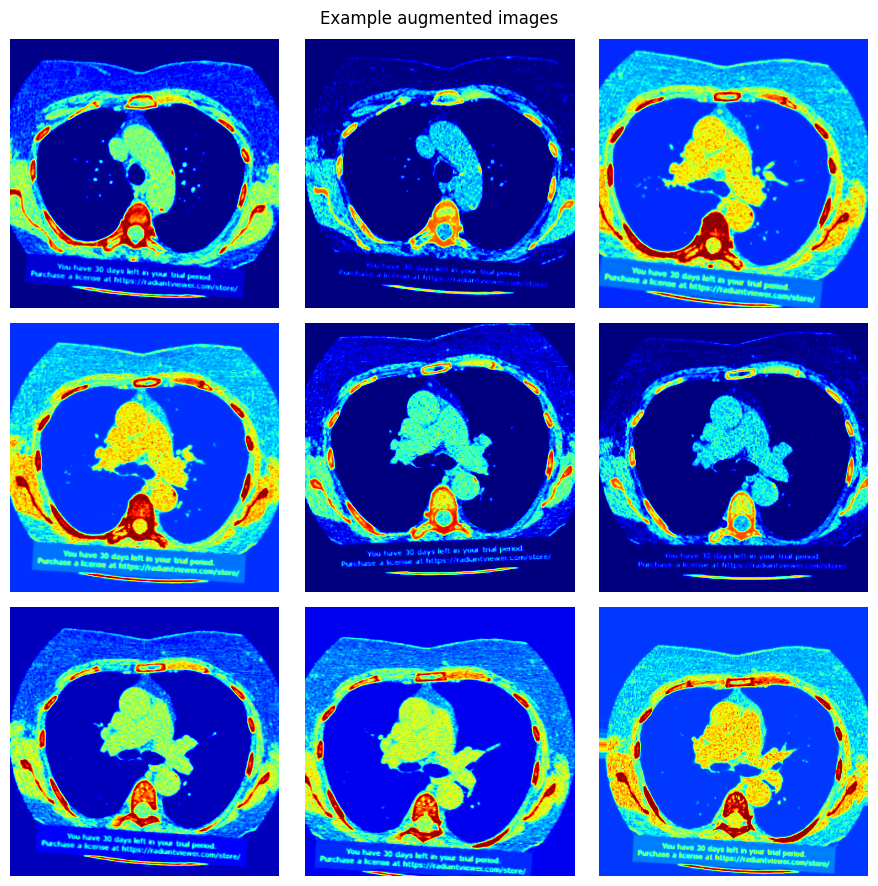

In [26]:
# plot augmented images
plt.figure(figsize=(9, 9))
for batch in aug_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(batch[i].numpy().astype("uint8"), cmap="jet", vmin=0, vmax=255)
        plt.axis("off")
plt.suptitle("Example augmented images")
plt.tight_layout()

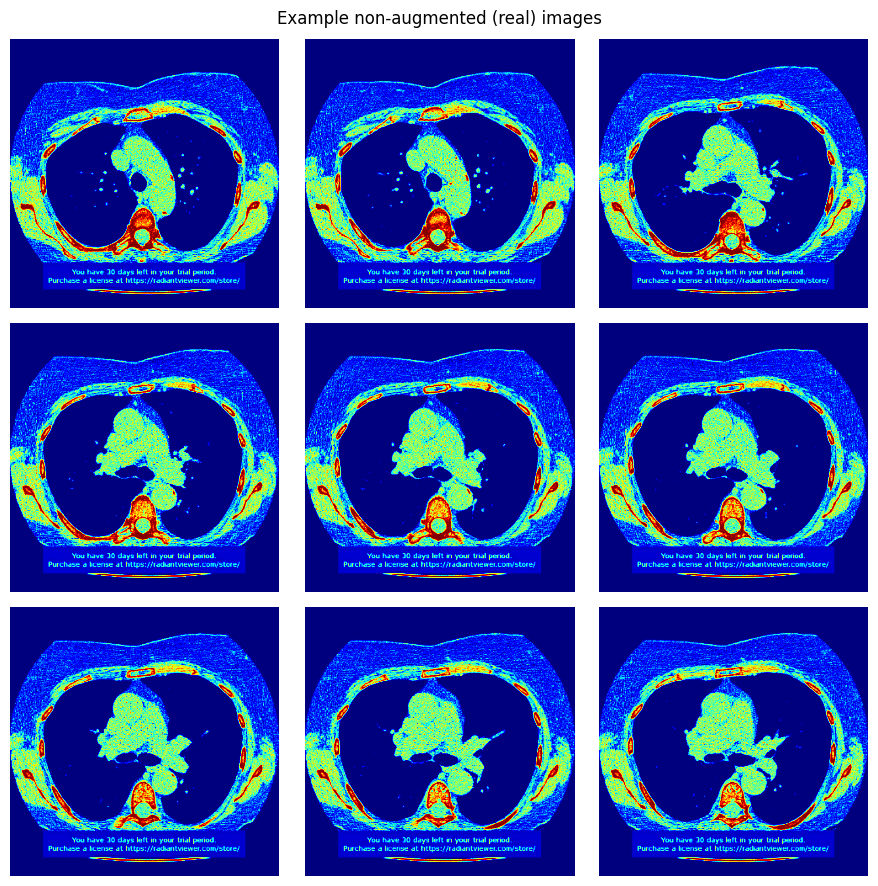

In [27]:
# plot non-augmented images
plt.figure(figsize=(9, 9))
for batch in pos_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(batch[i].numpy().astype("uint8"), cmap="jet", vmin=0, vmax=255)
        plt.axis("off")
plt.suptitle("Example non-augmented (real) images")
plt.tight_layout()

In [28]:
#################
# load datasets #
#################

train_ds = image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    validation_split=0.2,
    subset="training",
    color_mode="grayscale",
    seed=0,
    image_size=(img_height, img_width),
    batch_size=None
)

val_ds = image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    validation_split=0.2,
    subset="validation",
    color_mode="grayscale",
    seed=0,
    image_size=(img_height, img_width),
    batch_size=None
)

test_ds = image_dataset_from_directory(
    test_data_dir,
    labels="inferred",
    color_mode="grayscale",
    shuffle=False,
    image_size=(img_height, img_width),
    batch_size=None
)

Found 1624 files belonging to 2 classes.
Using 1300 files for training.
Found 1624 files belonging to 2 classes.
Using 324 files for validation.
Found 405 files belonging to 2 classes.


In [29]:
##############################
# runtime augmentation model #
##############################

data_augmentation = tf.keras.Sequential(
    [
        layers.RandomTranslation(
            height_factor=(-0.05, 0.05),
            width_factor=(-0.05, 0.05),
            fill_mode="nearest",
        ),
        layers.RandomRotation(
            factor=(-0.025, 0.025),
            fill_mode="nearest",
        ),
        layers.RandomBrightness(
            factor=(-0.1, 0.1)
        ),
        layers.RandomContrast(
            factor=0.2
        ),
        layers.RandomZoom(
            height_factor=(-0.1, 0.025)
        ),
    ]
)

In [30]:
########################
# function definitions #
########################

def prepare(ds: tf.data.Dataset, shuffle=False, augment=False):
    """
    Function to prepare a given dataset for passing into a model.
    This function implements augmentation and buffering as well.
    """

    if shuffle:
        ds = ds.shuffle(1000)

    # Batch all datasets.
    ds = ds.batch(batch_size)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(
            lambda image, label: (
                (data_augmentation(image, training=True), label)
            ),
            num_parallel_calls=AUTOTUNE
        )

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

In [31]:
# prepare datasets
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [32]:
# model definition
model = tf.keras.Sequential(
    [
        layers.Resizing(img_height, img_width),
        layers.Rescaling(1./255),
        Conv2D(16, 16, padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPool2D(),
        Conv2D(32, 8, padding='same', activation="relu"),
        MaxPool2D(),
        Conv2D(64, 4, padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPool2D(),
        Flatten(),
        Dense(128),
        BatchNormalization(),
        ReLU(),
        Dense(1, activation="sigmoid")
    ]
)

In [33]:
# compile
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.binary_crossentropy,
    metrics=['accuracy']
)

In [58]:
#########
# train #
#########

epochs = 30

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
41/41 [==============================] - 20s 346ms/step - loss: 0.5211 - accuracy: 0.7431 - val_loss: 0.5586 - val_accuracy: 0.7037
Epoch 2/30
41/41 [==============================] - 18s 350ms/step - loss: 0.5156 - accuracy: 0.7392 - val_loss: 0.5492 - val_accuracy: 0.7531
Epoch 3/30
41/41 [==============================] - 19s 343ms/step - loss: 0.5087 - accuracy: 0.7546 - val_loss: 0.5257 - val_accuracy: 0.7284
Epoch 4/30
41/41 [==============================] - 20s 356ms/step - loss: 0.5039 - accuracy: 0.7546 - val_loss: 0.6441 - val_accuracy: 0.6728
Epoch 5/30
41/41 [==============================] - 19s 381ms/step - loss: 0.4855 - accuracy: 0.7631 - val_loss: 0.4661 - val_accuracy: 0.7747
Epoch 6/30
41/41 [==============================] - 20s 351ms/step - loss: 0.4914 - accuracy: 0.7662 - val_loss: 0.5311 - val_accuracy: 0.7253
Epoch 7/30
41/41 [==============================] - 18s 358ms/step - loss: 0.4907 - accuracy: 0.7600 - val_loss: 0.5007 - val_accuracy: 0.7685

NameError: name 'history' is not defined

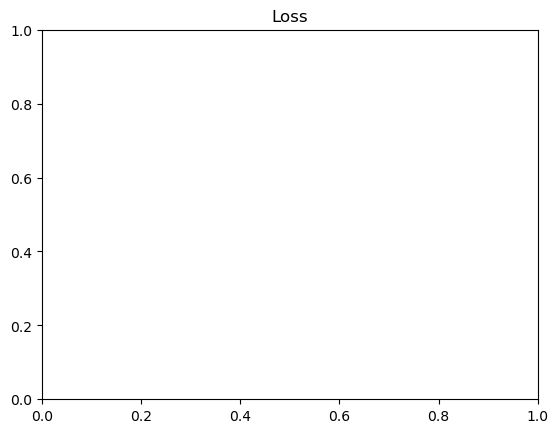

In [3]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show();

In [60]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 320, 320, 1)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 320, 320, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 320, 320, 16)      4112      
                                                                 
 batch_normalization_3 (Bat  (None, 320, 320, 16)      64        
 chNormalization)                                                
                                                                 
 re_lu_3 (ReLU)              (None, 320, 320, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 160, 160, 16)      0         
 g2D)                                                 

In [66]:
model.save(BASE_DIR + 'colab_model.keras')

In [67]:
new_model = tf.keras.models.load_model(BASE_DIR + 'colab_model.keras')

In [68]:
predictions = np.array([])
labels = np.array([])

for x, y in test_ds:
    predictions = np.concatenate([predictions, new_model.predict(x).flatten()])
    labels = np.concatenate([labels, y.numpy()])

1/1 [==============================] - 0s 128ms/step


In [69]:
tf.math.confusion_matrix(labels=labels, predictions=predictions.round()).numpy()

array([[222,  23],
       [ 31, 129]], dtype=int32)

In [70]:
f1_score(labels, predictions.round())

0.826923076923077

In [64]:
print(classification_report(labels, predictions.round()))

              precision    recall  f1-score   support

         0.0       0.88      0.91      0.89       245
         1.0       0.85      0.81      0.83       160

    accuracy                           0.87       405
   macro avg       0.86      0.86      0.86       405
weighted avg       0.87      0.87      0.87       405

